# Are there Persistening Effects of the Berlin Divison on short-term AirBnB Market in Germany?

In XXX, in Berlin, Germany the XXX divided the city into East-Germany and West Germany.  The wall stood from XXX to XXX.  The characterists of East-Germany are XXX. The characteristis of West-Germany are XXX. Today, the split 


Aayush Dhakal, Nicols Pazos, Sharanya Bhattacharjee, and Melissa Carson
ACE 592,  2025

- [Table of Contents](#toc1_)    
    - [**Data Background**](#toc1_1)
    - [**Data Preparation**](#toc1_1)
    - [**Categorical Differences**](#toc1_1_2)    
    - [**Spatial Analysis**](#toc1_1_2)       
    - [**Sentiment Analysis**](#toc1_1_3)    
    - [**Numeric Analysis**](#toc1_1_4)    
    - [**Granular Analysis**](#toc1_1_6)    
    - [**Other Analyses**](#toc1_1_7)  

[**Data Background**](#toc1_1)

The Data is from Inside AirBnB, https://insideairbnb.com/berlin/

Inside AirBnB Description: "Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. We work towards a vision where communities are empowered with data and information to understand, decide and control the role of renting residential homes to tourists...Inside Airbnb is mission-driven and supports residents and activists who are organising to protect their communities from the negative effects of short-term rentals. Inside Airbnb deeply believes in the power of community, in sharing resources and celebrating successes."

Documentation of Data Assumptions, https://insideairbnb.com/data-assumptions/

Summary of relevant Data Assumptions and Limitations:
 - "Location information for listings are anonymized by Airbnb.
In practice, this means the location for a listing on the map, or in the data will be from 0-450 feet (150 metres) of the actual address.
Listings in the same building are anonymized by Airbnb individually, and therefore may appear "scattered" in the area surrounding the actual address."
 - "Neighbourhood names for each listing are compiled by comparing the listing's geographic coordinates with a city's definition of neighbourhoods. Airbnb neighbourhood names are not used because of their inaccuracies."
- "The Airbnb calendar for a listing does not differentiate between a booked night vs an unavailable night, therefore these bookings have been counted as 'unavailable'. This serves to understate the Availability metric because popular listings will be "booked" rather than being 'blacked out' by a host."
- "One of the biggest issues with Airbnb is whether hosts are renting out residential properties permanently as hotels, as opposed to sharing the primary residence in which they live 'occasionally'. An occupancy model can be used to estimate how often an Airbnb listing is being rented out, and also approximate a listing's income."
- "A Review Rate of 50% is used to convert reviews to estimated bookings."
- "An average length of stay, where avaialble, is configured for each city, and this, multiplied by the estimated bookings for each listing over a period gives the occupancy rate"



[**Data Preparation**](#toc1_1)


In [1]:
# I think this is everything we used on HW  + HW 1 + HW 2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import json
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.colors as pltc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
from nltk.corpus import stopwords
import string
import emoji
from datetime import timedelta


In [45]:
### I think this will work for mac users, dont know for windows..
data_dir= "~/Library/CloudStorage/Box-Box/Data Science Project"


In [5]:
###
### AIRBNB DATA
###

# For each respective csv in each respective month, open and append together. 
# The months are 03, 06, 09, 12
# The names of the csv are 1) listings 2) neighbourhoods 3) reviews 4) calendar
# The folder structre is 2021-XX where XX is the month, inside each folder is the csv name


import pandas as pd
import os

months = ['03', '06', '09', '12']
csv_names = ['listings.csv', 'neighbourhoods.csv', 'reviews.csv']

combined_data = {name: [] for name in csv_names}

for month in months:
    folder = f"2024-{month}"
    for csv_file in csv_names:
        file_path = f"{data_dir}/{folder}/{csv_file}"
        try:
            df = pd.read_csv(file_path)
            df['source_month'] = month
            combined_data[csv_file].append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Combine each list of DataFrames into a single one
listings_df = pd.concat(combined_data['listings.csv'], ignore_index=True)
neighbourhoods_df = pd.concat(combined_data['neighbourhoods.csv'], ignore_index=True)
reviews_df = pd.concat(combined_data['reviews.csv'], ignore_index=True)


In [47]:
listings_df.head(5)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,source_month
0,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,83.0,63,148,2023-05-25,0.82,1,112,1,First name and Last name: Nicolas Krotz <br/> ...,03
1,9991,Geourgeous flat - outstanding views,33852,Philipp,Pankow,Prenzlauer Berg Südwest,52.53269,13.41805,Entire home/apt,180.0,6,7,2020-01-04,0.07,1,17,0,03/Z/RA/003410-18,03
2,14325,Studio Apartment in Prenzlauer Berg,55531,Chris + Oliver,Pankow,Prenzlauer Berg Nordwest,52.54813,13.40366,Entire home/apt,70.0,150,26,2023-11-30,0.16,4,204,1,NaN,03
3,16644,In the Heart of Berlin - Kreuzberg,64696,Rene,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50312,13.43508,Entire home/apt,90.0,93,48,2017-12-14,0.29,2,230,0,NaN,03
4,17904,Beautiful Kreuzberg studio - 3 months minimum,68997,Matthias,Neukölln,Reuterstraße,52.49419,13.42166,Entire home/apt,25.0,92,299,2022-12-01,1.74,1,1,0,NaN,03


In [50]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point  # Needed for creating geometry


In [51]:
berlin = geopandas.read_file(data_dir+"/berlin.json")

In [52]:

# Convert Airbnb data to GeoDataFrame
geometry = [Point(xy) for xy in zip(listings_df['longitude'], listings_df['latitude'])]
airbnb_gdf = gpd.GeoDataFrame(listings_df, geometry=geometry, crs="EPSG:4326")

# Reproject Germany map to match Airbnb CRS if necessary
if berlin.crs != berlin.crs:
    berlin = berlin.to_crs(airbnb_gdf.crs)


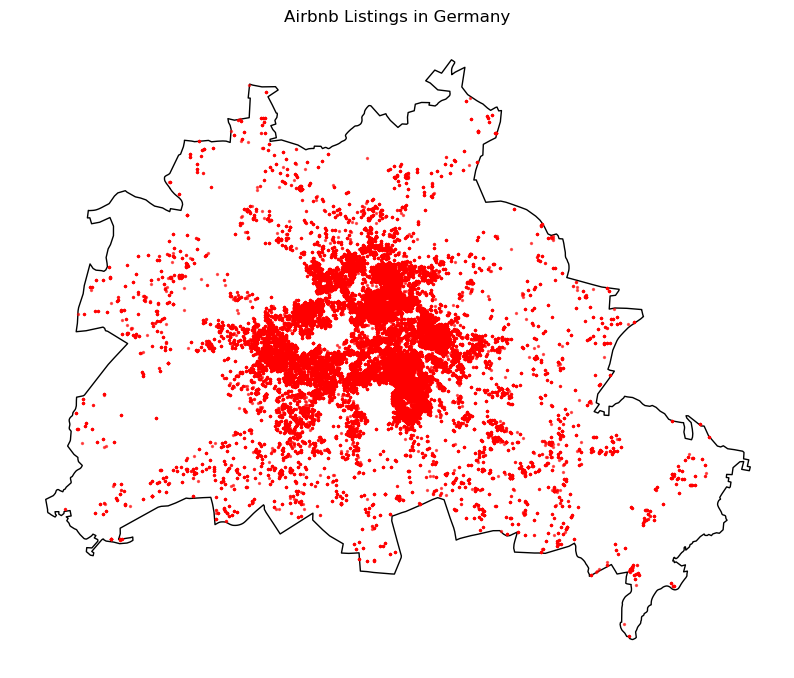

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
berlin.plot(ax=ax, color='white', edgecolor='black')
airbnb_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.6)
plt.title("Airbnb Listings in Germany")
plt.axis("off")
plt.show()

In [54]:
berlin_wall = geopandas.read_file(data_dir+"/berlin_wall.json")

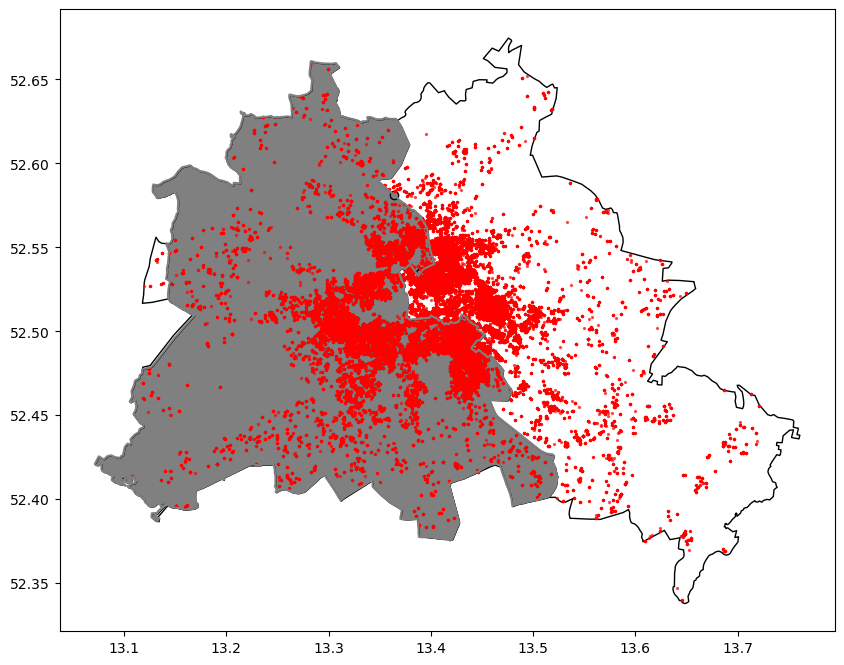

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
berlin.plot(ax=ax, color='white', edgecolor='black')
berlin_wall.plot(ax=ax, color='grey', edgecolor='black')
airbnb_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.6)

plt.show()

In [56]:
if berlin_wall.crs != berlin.crs:
    berlin_wall = berlin_wall.to_crs(berlin.crs)

# Subtract West Berlin from Berlin to get East Berlin
west_berlin_shape = berlin_wall.unary_union
berlin_shape = berlin.unary_union
east_berlin_shape = berlin_shape.difference(west_berlin_shape)

# Convert to GeoDataFrame
east_berlin_gdf = gpd.GeoDataFrame(geometry=[east_berlin_shape], crs=berlin.crs)

/var/folders/p9/fmzq3dpx4vz5c6jcmsdcn_n80000gn/T/ipykernel_6060/207473935.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  west_berlin_shape = berlin_wall.unary_union
/var/folders/p9/fmzq3dpx4vz5c6jcmsdcn_n80000gn/T/ipykernel_6060/207473935.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  berlin_shape = berlin.unary_union


In [57]:
east_parts = east_berlin_gdf.explode(index_parts=True).reset_index(drop=True)
largest_geom = east_parts.loc[east_parts.area.idxmax()]
east_berlin = gpd.GeoDataFrame(geometry=[largest_geom.geometry], crs=east_parts.crs)

wall_parts = berlin_wall.explode(index_parts=True).reset_index(drop=True)
largest_wall = wall_parts.loc[wall_parts.area.idxmax()]
west_berlin = gpd.GeoDataFrame(geometry=[largest_wall.geometry], crs=wall_parts.crs)


/var/folders/p9/fmzq3dpx4vz5c6jcmsdcn_n80000gn/T/ipykernel_6060/1538850594.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  largest_geom = east_parts.loc[east_parts.area.idxmax()]
/var/folders/p9/fmzq3dpx4vz5c6jcmsdcn_n80000gn/T/ipykernel_6060/1538850594.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  largest_wall = wall_parts.loc[wall_parts.area.idxmax()]


In [58]:
from shapely.geometry import LineString, MultiLineString, GeometryCollection

east_geom = east_berlin.geometry.iloc[0]
west_geom = west_berlin.geometry.iloc[0]
# Assume this from intersection
intersection = east_geom.boundary.intersection(west_geom.boundary)

# If it's a GeometryCollection, extract only the line-like geometries
if isinstance(intersection, GeometryCollection):
    line_parts = [geom for geom in intersection.geoms if isinstance(geom, (LineString, MultiLineString))]
    # Merge to MultiLineString if needed
    if len(line_parts) > 1:
        dividing_line = MultiLineString(line_parts)
    elif len(line_parts) == 1:
        dividing_line = line_parts[0]
    else:
        dividing_line = None  # No valid line
else:
    dividing_line = intersection  # Already a line


dividing_line_gdf = gpd.GeoDataFrame(geometry=[dividing_line], crs=east_berlin.crs)

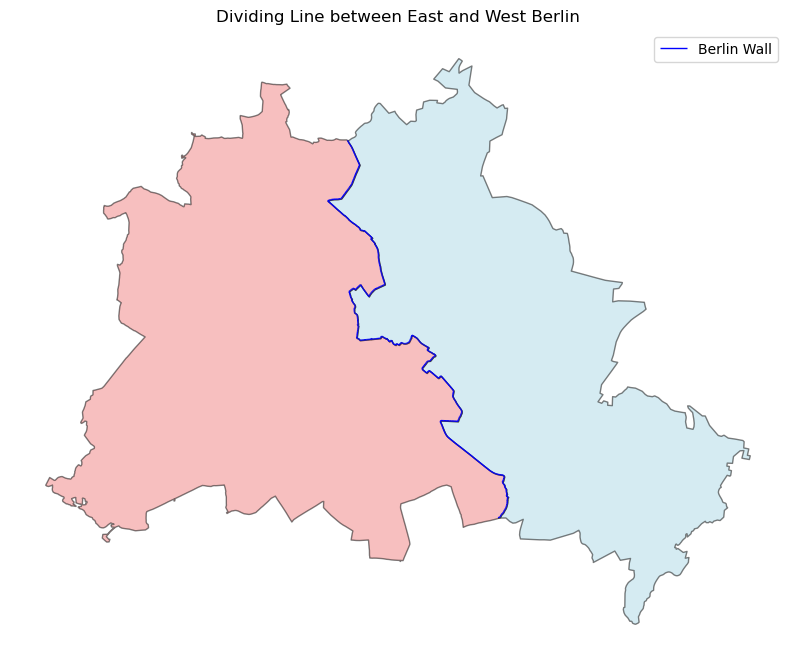

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
east_berlin.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.5)
west_berlin.plot(ax=ax, facecolor='lightcoral', edgecolor='black', alpha=0.5)
dividing_line_gdf.plot(ax=ax, color='blue', linewidth=1, label='Berlin Wall')

plt.title("Dividing Line between East and West Berlin")
plt.axis("off")
plt.legend()
plt.show()


In [60]:
assert airbnb_gdf.crs == east_berlin.crs == berlin_wall.crs

#  Define masks for each region
in_east = airbnb_gdf.within(east_berlin.geometry.iloc[0])
in_west = airbnb_gdf.within(west_berlin.geometry.iloc[0])

# Assign categories
airbnb_gdf["region"] = "Unknown"  # Default
airbnb_gdf.loc[in_east, "region"] = "East Berlin"
airbnb_gdf.loc[in_west, "region"] = "West Berlin"
airbnb_gdf.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,source_month,geometry,region
0,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,83.0,...,148,2023-05-25,0.82,1,112,1,First name and Last name: Nicolas Krotz <br/> ...,03,POINT (13.4181 52.53471),East Berlin
1,9991,Geourgeous flat - outstanding views,33852,Philipp,Pankow,Prenzlauer Berg Südwest,52.53269,13.41805,Entire home/apt,180.0,...,7,2020-01-04,0.07,1,17,0,03/Z/RA/003410-18,03,POINT (13.41805 52.53269),East Berlin
2,14325,Studio Apartment in Prenzlauer Berg,55531,Chris + Oliver,Pankow,Prenzlauer Berg Nordwest,52.54813,13.40366,Entire home/apt,70.0,...,26,2023-11-30,0.16,4,204,1,NaN,03,POINT (13.40366 52.54813),East Berlin
3,16644,In the Heart of Berlin - Kreuzberg,64696,Rene,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.50312,13.43508,Entire home/apt,90.0,...,48,2017-12-14,0.29,2,230,0,NaN,03,POINT (13.43508 52.50312),West Berlin
4,17904,Beautiful Kreuzberg studio - 3 months minimum,68997,Matthias,Neukölln,Reuterstraße,52.49419,13.42166,Entire home/apt,25.0,...,299,2022-12-01,1.74,1,1,0,NaN,03,POINT (13.42166 52.49419),West Berlin


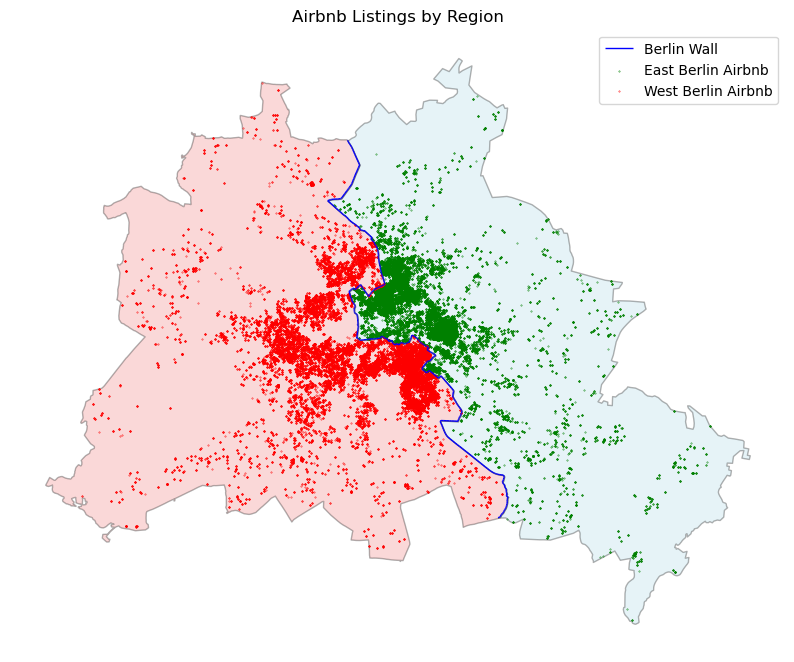

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
east_berlin.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.3)
west_berlin.plot(ax=ax, facecolor='lightcoral', edgecolor='black', alpha=0.3)
dividing_line_gdf.plot(ax=ax, color='blue', linewidth=1, label='Berlin Wall')

airbnb_gdf[airbnb_gdf["region"] == "East Berlin"].plot(ax=ax, color='green', markersize=.1, label='East Berlin Airbnb')
airbnb_gdf[airbnb_gdf["region"] == "West Berlin"].plot(ax=ax, color='red', markersize=0.1, label='West Berlin Airbnb')

plt.title("Airbnb Listings by Region")
plt.axis("off")
plt.legend()
plt.show()

In [62]:
airbnb_proj = airbnb_gdf.to_crs(epsg=32633)
wall_proj = dividing_line_gdf.to_crs(epsg=32633)

# Get the wall geometry (assuming one geometry)
wall_geom = wall_proj.geometry.iloc[0]

# Calculate distance to the wall line for each Airbnb point
airbnb_proj["distance_to_wall_m"] = airbnb_proj.geometry.distance(wall_geom)

In [63]:
# Keep only Airbnb listings within 1 km (1,000 meters) of the wall
near_wall = airbnb_proj[airbnb_proj["distance_to_wall_m"] <= 1000]
east_near_wall = near_wall[near_wall["region"] == "East Berlin"]
west_near_wall = near_wall[near_wall["region"] == "West Berlin"]

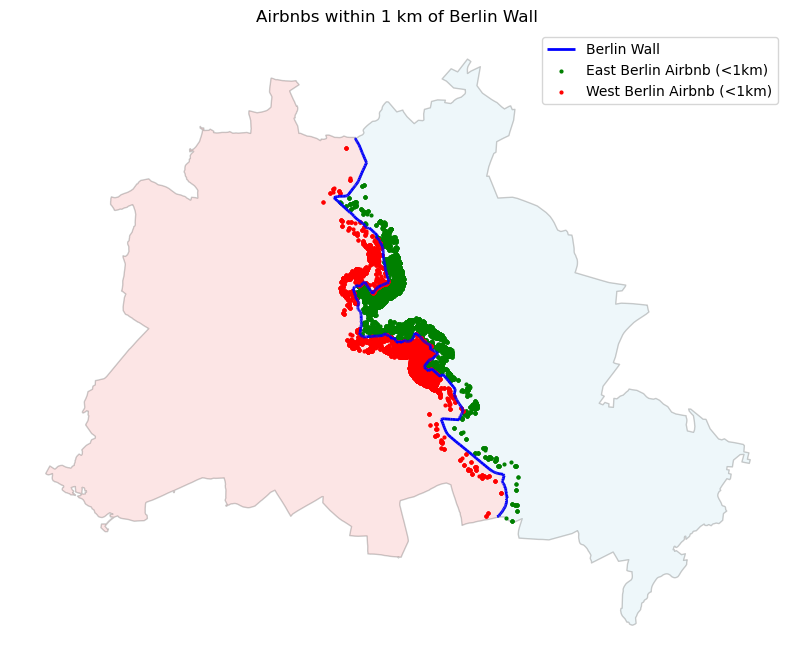

In [64]:

fig, ax = plt.subplots(figsize=(10, 10))

east_berlin.to_crs(epsg=32633).plot(ax=ax, facecolor='lightblue', alpha=0.2, edgecolor='black')
west_berlin.to_crs(epsg=32633).plot(ax=ax, facecolor='lightcoral', alpha=0.2, edgecolor='black')
wall_proj.plot(ax=ax, color='blue', linewidth=2, label='Berlin Wall')

# Airbnb points
east_near_wall.plot(ax=ax, color='green', markersize=4, label='East Berlin Airbnb (<1km)')
west_near_wall.plot(ax=ax, color='red', markersize=4, label='West Berlin Airbnb (<1km)')

plt.title("Airbnbs within 1 km of Berlin Wall")
plt.axis("off")
plt.legend()
plt.show()


[**Categorical Differences**](#toc1_1_2)    


[**Spatial Analysis**](#toc1_1_2)    

[**Sentiment Analysis**](#toc1_1_3)    


[**Numeric Analysis**](#toc1_1_4) 

[**Granular Analysis**](#toc1_1_6)    


[**Other Analysis**](#toc1_1_7)
